# Analysis of Reference Region on Longitudinal SUVR

In [1]:
using Pkg
Pkg.status()

Status `~/Projects/local-fkpp/Project.toml`
  [3276ce4d] ADNIDatasets v0.1.0 `https://github.com/PavanChaggar/ADNIDatasets.jl.git#main`
  [0bf59076] AdvancedHMC v0.6.1
  [6e4b80f9] BenchmarkTools v1.5.0
  [336ed68f] CSV v0.10.14
  [55f7864d] Connectomes v0.1.0 `https://github.com/PavanChaggar/Connectomes.jl.git#main`
  [a93c6f00] DataFrames v1.6.1
  [0c46a032] DifferentialEquations v7.13.0
  [31c24e10] Distributions v0.25.108
  [634d3b9d] DrWatson v2.15.0
⌃ [86223c79] Graphs v1.10.0
  [7073ff75] IJulia v1.24.2
  [6fdf6af0] LogDensityProblems v2.1.1
  [996a588d] LogDensityProblemsAD v1.9.0
  [c7f686f2] MCMCChains v6.0.6
  [429524aa] Optim v1.9.4
  [43a3c2be] PairPlots v2.7.2
  [b1d3bc72] Pathfinder v0.8.3
  [91a5bcdd] Plots v1.40.4
  [08abe8d2] PrettyTables v2.3.1
⌃ [1ed8b502] SciMLSensitivity v7.56.2
  [f3b207a7] StatsPlots v0.15.7
  [fe2206b3] TidierData v0.15.2
⌃ [337ecbd1] TidierPlots v0.7.4
⌃ [fce5fe82] Turing v0.30.9
⌃ [e88e6eb3] Zygote v0.6.69
  [8ba89e20] Distributed
Info Packag

In [2]:
using Connectomes
using ADNIDatasets
using CSV, DataFrames
using DrWatson: projectdir
using Serialization
using DelimitedFiles
using CairoMakie
include(projectdir("functions.jl"))

regional_mean (generic function with 2 methods)

## Preamble

Loading the DKT parcellation and finding regions used to define tau status.

In [3]:
parc = Parcellation(Connectomes.connectome_path())
cortex = filter(x -> get_lobe(x) != "subcortex", parc);

dktdict = Connectomes.node2FS()
dktnames = [dktdict[i] for i in get_node_id.(cortex)];

mtl_regions = ["entorhinal", "Left-Amygdala", "Right-Amygdala"]
mtl = findall(x -> x ∈ mtl_regions, get_label.(cortex))
neo_regions = ["inferiortemporal", "middletemporal"]
neo = findall(x -> x ∈ neo_regions, get_label.(cortex));

## Data Preparation

Loading recent tau-PET AV1451 data from ADNI, with amyloid status appended. Loading the data using both inferior cerebellum and eroded white matter reference rgeions.
Note, we use the package `ADNIDatasets.jl` for convenient handling of tabular tau-PET data. Documentation for the package can be found at https://github.com/PavanChaggar/ADNIDatasets.jl. 

In [4]:
sub_data_path = projectdir("adni/data/new_new_data/UCBERKELEY_TAU_6MM_18Dec2023_AB_STATUS.csv")
alldf = CSV.read(sub_data_path, DataFrame);

posdf = filter(x -> x.AB_Status == 1, alldf)

ic_data = ADNIDataset(posdf, dktnames; min_scans=3, reference_region="INFERIORCEREBELLUM")
ic_data_with_wm = ADNIDataset(posdf, [dktnames; "ERODED_SUBCORTICALWM"; "CEREBELLUM_CORTEX"]; min_scans=3, reference_region="INFERIORCEREBELLUM")
wm_data = ADNIDataset(posdf, dktnames; min_scans=3, reference_region="ERODED_SUBCORTICALWM")
n_data = length(ic_data)

96

In [5]:
ic_all_vols = [reduce(vcat, [dkt, ref']) for (dkt, ref) in zip(get_vol.(ic_data), get_ref_vol.(ic_data))]
ic_tiv = sum.(ic_all_vols, dims=1)
ic_tiv_vols = [v ./ t for (v, t) in zip(ic_all_vols, ic_tiv)]
ic_ref_vols = [t[end, :] ./ t[end, 1] for t in ic_tiv_vols]
ic_vols = [t[1:72, :] ./ t[1:72,1] for t in ic_tiv_vols]

wm_all_vols = [reduce(vcat, [dkt, ref']) for (dkt, ref) in zip(get_vol.(wm_data), get_ref_vol.(wm_data))]
wm_tiv = sum.(wm_all_vols, dims=1)
wm_tiv_vols = [v ./ t for (v, t) in zip(wm_all_vols, wm_tiv)]
wm_ref_vols = [t[end, :] ./ t[end, 1] for t in wm_tiv_vols]
wm_vols = [t[1:72, :] ./ t[1:72,1] for t in wm_tiv_vols];

In [6]:
function regional_mean(data::ADNIDataset, rois, sub)
    subsuvr = calc_suvr.(data, sub)
    mean(subsuvr[rois,end])
end

regional_mean (generic function with 3 methods)

In [7]:
# Calculating tau status using the infereior cerebellum reference region. 
function regional_mean(data::Array{Float64}, rois)
    mean(data[rois,end])
end
mtl_mean(data::Array{Float64}) = regional_mean(data, mtl)
neo_mean(data::Array{Float64}) = regional_mean(data, neo)

ic_gmm_moments = CSV.read(projectdir("adni/data/component_moments.csv"), DataFrame)
ic_mtl_cutoff = 1.375
ic_neo_cutoff = 1.395

ic_mtl_pos_idx = findall(x -> x >= ic_mtl_cutoff, mtl_mean.(calc_suvr.(ic_data)))
ic_neo_pos_idx = findall(x -> x >= ic_neo_cutoff, neo_mean.(calc_suvr.(ic_data)))

ic_tau_pos_idx = findall(x -> x ∈ unique([ic_mtl_pos_idx; ic_neo_pos_idx]), 1:n_data)
ic_tau_neg_idx = findall(x -> x ∉ ic_tau_pos_idx, 1:n_data);

In [8]:
# Calculating tau status using the eroded white matter reference region. 
wm_gmm_moments = CSV.read(projectdir("py-analysis/wm-nopvc-moments-prob.csv"), DataFrame)
wm_mtl_cutoff = mean(wm_gmm_moments.cutoff[mtl])
wm_neo_cutoff = mean(wm_gmm_moments.cutoff[neo])

wm_mtl_pos_idx = findall(x -> x >= wm_mtl_cutoff, mtl_mean.(calc_suvr.(wm_data)))
wm_neo_pos_idx = findall(x -> x >= wm_neo_cutoff, neo_mean.(calc_suvr.(wm_data)))

wm_tau_pos_idx = findall(x -> x ∈ unique([wm_mtl_pos_idx; wm_neo_pos_idx]), 1:n_data)
wm_tau_neg_idx = findall(x -> x ∉ wm_tau_pos_idx, 1:n_data);

In [9]:
# Sorting A- data and calculating volumes

negdf = filter(x -> x.AB_Status == 0, alldf)
ic_negdata = ADNIDataset(negdf, dktnames; min_scans=3, reference_region="INFERIORCEREBELLUM")
ic_negdata_with_wm = ADNIDataset(negdf, [dktnames; "ERODED_SUBCORTICALWM"; "CEREBELLUM_CORTEX"]; min_scans=3, reference_region="INFERIORCEREBELLUM")
wm_negdata = ADNIDataset(negdf, dktnames; min_scans=3, reference_region="ERODED_SUBCORTICALWM")

ic_neg_all_vols = [reduce(vcat, [dkt, ref']) for (dkt, ref) in zip(get_vol.(ic_negdata), get_ref_vol.(ic_negdata))]
ic_neg_tiv = sum.(ic_neg_all_vols, dims=1)
ic_neg_tiv_vols = [v ./ t for (v, t) in zip(ic_neg_all_vols, ic_neg_tiv)]
ic_neg_ref_vols = [t[end, :] ./ t[end, 1] for t in ic_neg_tiv_vols]


wm_neg_all_vols = [reduce(vcat, [dkt, ref']) for (dkt, ref) in zip(get_vol.(wm_negdata), get_ref_vol.(wm_negdata))]
wm_neg_tiv = sum.(wm_neg_all_vols, dims=1)
wm_neg_tiv_vols = [v ./ t for (v, t) in zip(wm_neg_all_vols, wm_neg_tiv)]
wm_neg_ref_vols = [t[end, :] ./ t[end, 1] for t in wm_neg_tiv_vols];

# Longitudinal changes in regional SUVR

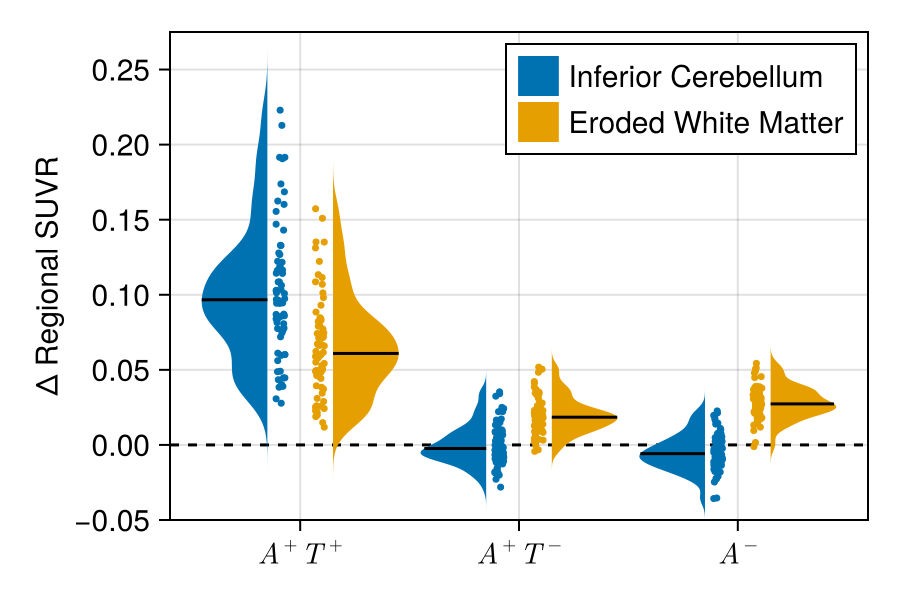

In [10]:
# Convenience functions for calculating longitudinal changes
function get_diff(x::Matrix{Float64})
    x[:,end] .- x[:,1]
end
function get_diff(x::Vector{Float64})
    x[end] - x[1]
end
cols = Makie.wong_colors();

begin
    f = Figure(size=(450, 300), fontsize=15)

    # Inferior Cerebellum 
    ax = Axis(f[1:5,1], ylabel="Δ Regional SUVR", xticks=(1:3, [L"A^+T^+", L"A^+T^-", L"A^-"]), yticks=-0.1:0.05:0.3)
    hlines!(ax, 0.0, linestyle=:dash, color=:black)

    ylims!(-0.05, 0.275)
    rainclouds!(ones(72) .* 0.85, mean(get_diff.(calc_suvr.(ic_data[ic_tau_pos_idx]))), plot_boxplots=false, cloud_width= 0.75, whiskerwidth=1, markersize=5, color=cols[1], label="Inferior Cerebellum")
    rainclouds!(ones(72) .* 1.15, mean(get_diff.(calc_suvr.(wm_data[wm_tau_pos_idx]))), plot_boxplots=false, cloud_width= 0.75, whiskerwidth=1, markersize=5, side=:right, color=cols[2],label="Eroded White Matter")

    rainclouds!(ones(72) .* 1.85, mean(get_diff.(calc_suvr.(ic_data[ic_tau_neg_idx]))), plot_boxplots=false, cloud_width= 0.75, whiskerwidth=1, markersize=5, color=cols[1], label="Inferior Cerebellum")
    rainclouds!(ones(72) .* 2.15, mean(get_diff.(calc_suvr.(wm_data[wm_tau_neg_idx]))), plot_boxplots=false, cloud_width= 0.75, whiskerwidth=1, markersize=5, side=:right, color=cols[2], label="Eroded White Matter")

    rainclouds!(ones(72) .* 2.85, mean(get_diff.(calc_suvr.(ic_negdata))), whiskerwidth=1, plot_boxplots=false, cloud_width= 0.75, markersize=5, color=cols[1], label="Inferior Cerebellum")
    rainclouds!(ones(72) .* 3.15, mean(get_diff.(calc_suvr.(wm_negdata))), whiskerwidth=1, plot_boxplots=false, cloud_width= 0.75, markersize=5, side=:right, color=cols[2], label="Eroded White Matter")
    
    axislegend(ax, merge=true, labelsize=15)
    f
end
save(projectdir("visualisation/reference_region/suvr-reference-region.pdf"), f)
f


The above figure shows the average change SUVR bewteen initial and most recent scans, for regions in the DKT atlas. Each raincloud plot is a summary over regions, with individual regions shown as scatter points. 

The figure shows that positive change is preserved for the A+T+ group when using the white matte reference regions. However, negative changes present in A+T- and A- groups with the inferior cerebellum reference regions are eliminated when the white matter reference region is used.

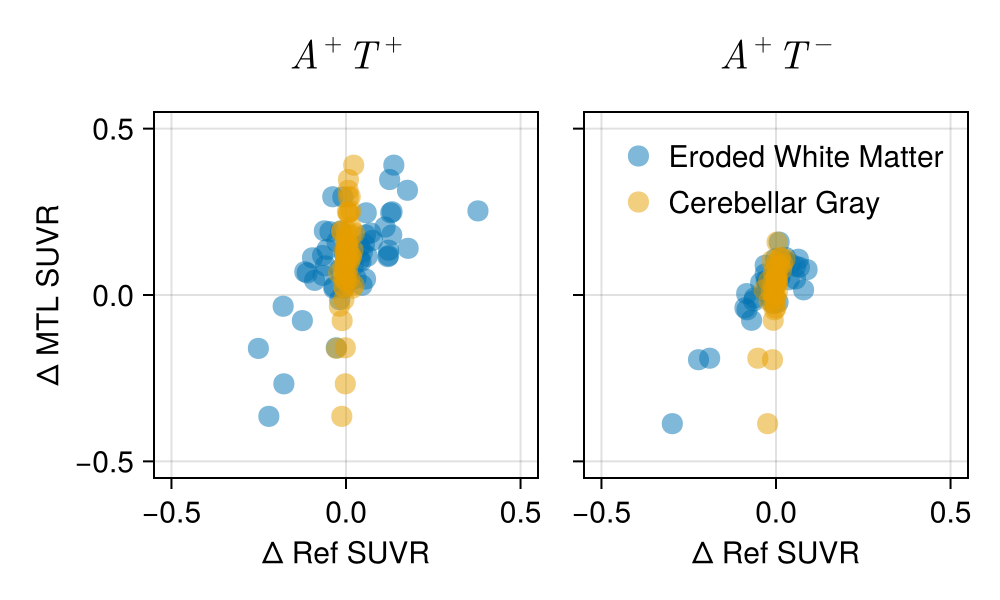

In [11]:
begin
    f = Figure(size=(500, 300), fontsize=15)

    # change white matter reference region SUVR vs 
    # change in MTL SUVR with infererior cerbeellum reference region
    # for A+T+
    ax = Axis(f[1,1], xlabel="Δ Ref SUVR", ylabel="Δ MTL SUVR", xticks=-0.5:0.5:0.5, yticks=-0.5:0.5:0.5)
    Label(f[0,1], L"A^+T^+", tellwidth=false, fontsize=20)
    xlims!(ax, -0.55, 0.55); ylims!(ax, -0.55, 0.55)
    for (wm, ic) in zip(wm_data[ic_tau_pos_idx], ic_data[ic_tau_pos_idx])
        scatter!(get_diff(get_ref_suvr(wm)), get_diff(vec(mean(calc_suvr(ic)[mtl,:], dims=1))), markersize=15, color=(cols[1], 0.5))
    end
    for (cg, ic) in zip(ic_data_with_wm[ic_tau_pos_idx], ic_data[ic_tau_pos_idx])
        scatter!(get_diff(calc_suvr(cg)[end,:]), get_diff(vec(mean(calc_suvr(ic)[mtl,:], dims=1))), markersize=15, color=(cols[2], 0.5))
    end
    # change white matter reference region SUVR vs 
    # change in MTL SUVR with infererior cerbeellum reference region
    # for A+T-
    ax = Axis(f[1,2], xlabel="Δ Ref SUVR", ylabel="Δ MTL SUVR",  xticks=-0.5:0.5:0.5, yticks=-0.5:0.5:0.5)
    Label(f[0,2], L"A^+T^-", tellwidth=false, fontsize=20)
    xlims!(ax, -0.55, 0.55); ylims!(ax, -0.55, 0.55)
    hideydecorations!(ax, ticks=false, grid=false)
    for (wm, ic) in zip(wm_data[ic_tau_neg_idx], ic_data[ic_tau_neg_idx])
        scatter!(get_diff(get_ref_suvr(wm)), get_diff(vec(mean(calc_suvr(ic)[mtl,:], dims=1))), markersize=15, color=(cols[1], 0.5), label="Eroded White Matter")
    end
    for (cg, ic) in zip(ic_data_with_wm[ic_tau_neg_idx], ic_data[ic_tau_neg_idx])
        scatter!(get_diff(calc_suvr(cg)[end,:]), get_diff(vec(mean(calc_suvr(ic)[mtl,:], dims=1))), markersize=15, color=(cols[2], 0.5), label="Cerebellar Gray")
    end
    axislegend(ax, unique=:true, merge=:true, labelsize=15, framevisible=false)

    # change in cerebellum cortex SUVR vs 
    # change in MTL SUVR with infererior cerbeellum reference region
    # for A+T+
    # ax = Axis(f[2,1], xlabel="Δ Cere. SUVR", ylabel="Δ MTL SUVR",  xticks=-0.5:0.5:0.5, yticks=-0.5:0.5:0.5)
    # xlims!(ax, -0.55, 0.55); ylims!(ax, -0.55, 0.55)
    # for (cg, ic) in zip(ic_data_with_wm[ic_tau_pos_idx], ic_data[ic_tau_pos_idx])
    #     scatter!(get_diff(calc_suvr(cg)[end,:]), get_diff(vec(mean(calc_suvr(ic)[mtl,:], dims=1))), markersize=10, color=(cols[1], 0.5))
    # end

    # change in cerebellum cortex SUVR vs 
    # change in MTL SUVR with infererior cerbeellum reference region
    # for A+T-
    # ax = Axis(f[2,2], xlabel="Δ Cere. SUVR", ylabel="Δ MTL SUVR",  xticks=-0.5:0.5:0.5, yticks=-0.5:0.5:0.5)
    # xlims!(ax, -0.55, 0.55); ylims!(ax, -0.55, 0.55)
    # hideydecorations!(ax, ticks=false, grid=false)
    # # for (d, vol) in zip(wm_data, wm_ref_vols)
    # #     scatter!(get_diff(get_ref_suvr(d)), get_diff(vol), color=:blue, markersize=15)
    # # end
    # for (cg, ic) in zip(ic_data_with_wm[ic_tau_neg_idx], ic_data[ic_tau_neg_idx])
    #     scatter!(get_diff(calc_suvr(cg)[end,:]), get_diff(vec(mean(calc_suvr(ic)[mtl,:], dims=1))), markersize=10, color=(cols[1], 0.5))
    # end
    f
    save(projectdir("visualisation/reference_region/mtl-vs-reference-region.pdf"), f)
end
f

We next look at the change in reference region suvr compared to change in medial temporal lobe SUVR (calculating using the default inferior cerbellar reference region). 

The top row of the above figure shows the change in eroded white matter (EWM) SUVR vs change in medial temporal lobe SUVR. The bottom row shows change in 
cereballar SUVR vs change in medial temporal lobe SUVR. Note that the ADNI data data are provided already normalised by inferior cerebellum SUVR, making these values inaccessible. We use the cerebellar SUVR as a proxy for the inferior cerebellum SUVR. 

This shows that cerbellar SUVR Is more stable longitudinally compared to eroded white matter, which shows a positive correlation with changes in medial temporal SUVR. 

We next invesigate whether this is due to atrophy of the reference region. 

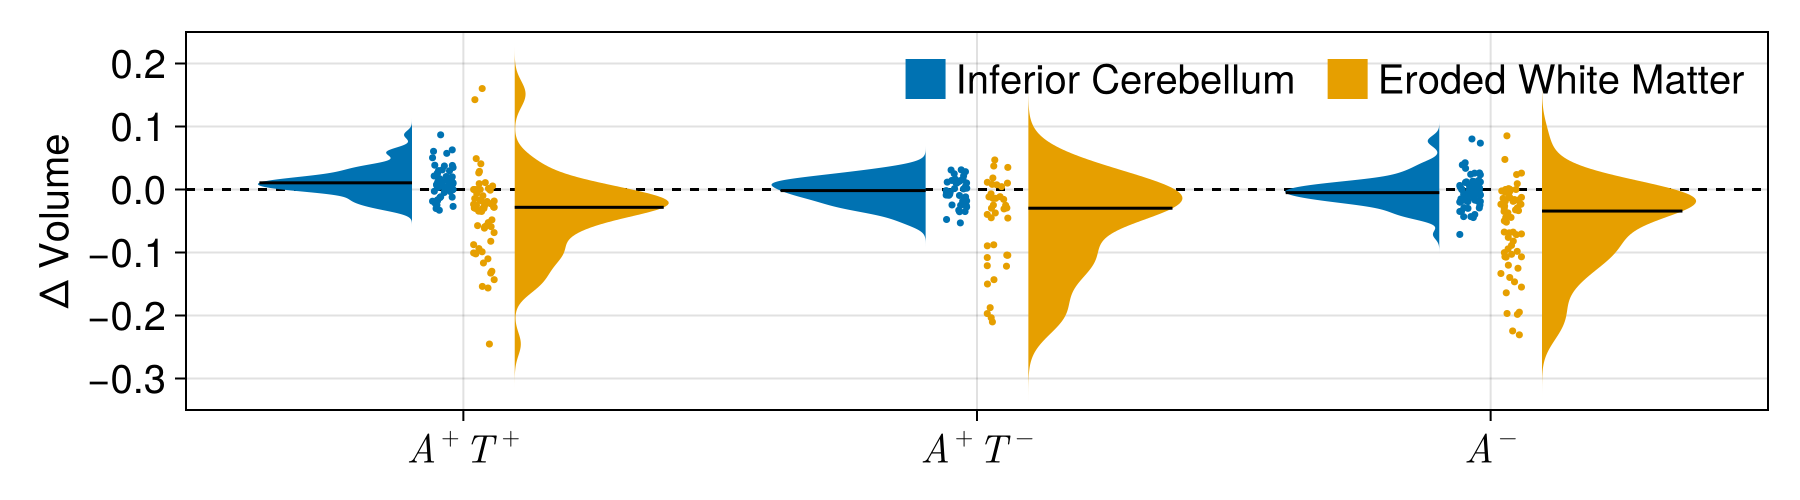

In [12]:
begin
    f = Figure(size=(900, 250), fontsize=20)
    ax = Axis(f[1,1], ylabel="Δ Volume", yticks=-0.3:0.1:0.3, xticks=(1:1:3, [L"A^+T^+", L"A^+T^-", L"A^-"]))
    hlines!(ax, 0.0, linestyle=:dash, color=:black)

    ylims!(ax, -0.35, 0.25)
    ic_ref_vol_diff = get_diff.(ic_ref_vols[ic_tau_pos_idx])
    wm_ref_vol_diff = get_diff.(wm_ref_vols[wm_tau_pos_idx])
    rainclouds!(ones(length(ic_ref_vol_diff)) .* 0.9,      ic_ref_vol_diff, plot_boxplots=false,cloud_width=0.75, whiskerwidth=1, markersize=5, color=cols[1], label="Inferior Cerebellum")
    rainclouds!(ones(length(wm_ref_vol_diff)) .* 1.1,      wm_ref_vol_diff, plot_boxplots=false,cloud_width=0.75, whiskerwidth=1, markersize=5, side=:right, color=cols[2], label="Eroded White Matter")

    ic_ref_vol_diff = get_diff.(ic_ref_vols[ic_tau_neg_idx])
    wm_ref_vol_diff = get_diff.(wm_ref_vols[wm_tau_neg_idx])
    rainclouds!(ones(length(ic_ref_vol_diff)) .* 1.9,      ic_ref_vol_diff, plot_boxplots=false,cloud_width=0.75, whiskerwidth=1, markersize=5, color=cols[1])
    rainclouds!(ones(length(wm_ref_vol_diff)) .* 2.1,      wm_ref_vol_diff, plot_boxplots=false,cloud_width=0.75, whiskerwidth=1, markersize=5, side=:right, color=cols[2])

    ic_ref_vol_diff = get_diff.(ic_neg_ref_vols)
    wm_ref_vol_diff = get_diff.(wm_neg_ref_vols)
    rainclouds!(ones(length(ic_ref_vol_diff)) .* 2.9,      ic_ref_vol_diff, plot_boxplots=false,cloud_width=0.75, whiskerwidth=1, markersize=5, color=cols[1])
    rainclouds!(ones(length(wm_ref_vol_diff)) .* 3.1,      wm_ref_vol_diff, plot_boxplots=false,cloud_width=0.75, whiskerwidth=1, markersize=5, side=:right, color=cols[2])
    elem_1 = [PolyElement(color = cols[1])]
    elem_2 = [PolyElement(color = cols[2])]
    axislegend(ax, merge=:true, unique=:true, framevisible=false, orientation=:horizontal)
    # Legend(f[1, 2],
    # [elem_1, elem_2],
    # ["Inferior \nCerebellum", "Eroded \nWhite \nMatter",], patchsize = (20, 20), framevisible=false)
    save(projectdir("visualisation/reference_region/vol-reference-region.pdf"), f)
end
f

Finally, we show the longitudinal change in reference volumes for the inferior cerebellum (blue) and eroded white matter (yellow). For all of the cohorts, A+T+, A+T- and A-, the eroded white matter shows substantially more variability in volume change, on average decreasing. Conversely, the longitudinal volume for the inferior cerbellum is much  more stable over time, showing minimal changes in volume.

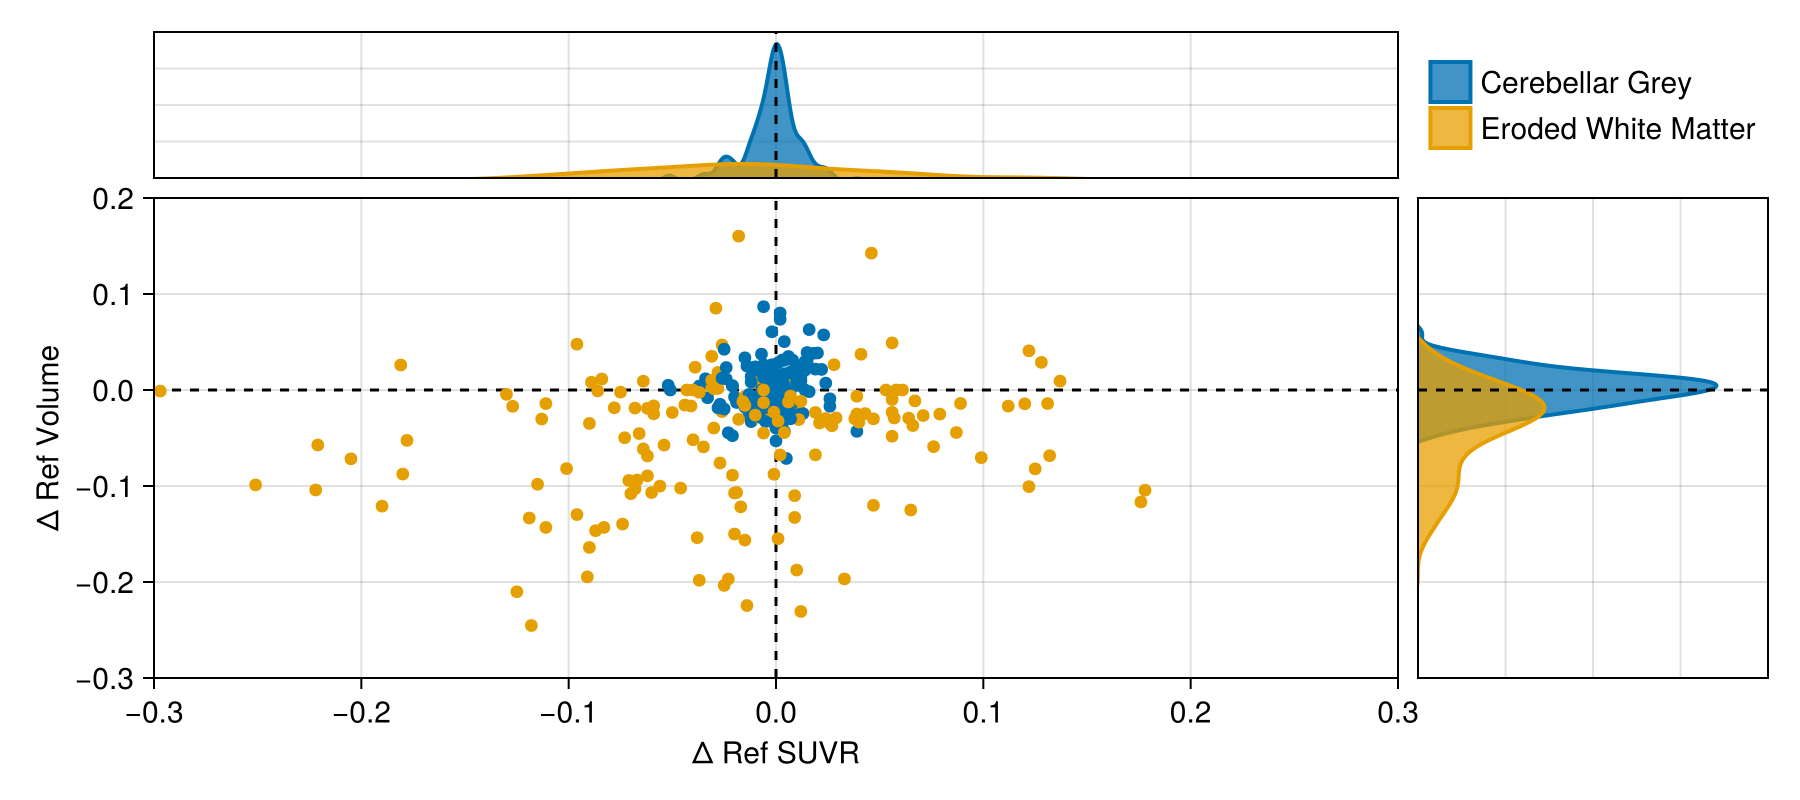

In [18]:
begin
    f = Figure(size=(900, 400), fontsize=15)
    ax = Axis(f[2:4,1:3], ylabel="Δ Ref Volume", xlabel= "Δ Ref SUVR", yticks=-0.3:0.1:0.3, xticks=-0.3:0.1:0.3)
    ylims!(-0.3, 0.2)
    xlims!(-0.3, 0.3)

    hlines!(ax, 0.0, color=:black, linestyle=:dash)
    vlines!(ax, 0.0, color=:black, linestyle=:dash)

    pos_ic_ref_vol_diff = get_diff.(ic_ref_vols[ic_tau_pos_idx])
    pos_wm_ref_vol_diff = get_diff.(wm_ref_vols[ic_tau_pos_idx])
    
    pos_ic_ref_suvr_diff = [get_diff(x[end,:]) for x in calc_suvr.(ic_data_with_wm[ic_tau_pos_idx])]
    pos_wm_ref_suvr_diff = get_diff.(get_ref_suvr.(wm_data[ic_tau_pos_idx]))

    scatter!(pos_ic_ref_suvr_diff, pos_ic_ref_vol_diff, color=cols[1])
    scatter!(pos_wm_ref_suvr_diff, pos_wm_ref_vol_diff, color=cols[2])

    # ax = Axis(f[1,2], ylabel="Δ Volume", yticks=-0.3:0.1:0.3)

    neg_ic_ref_vol_diff = get_diff.(ic_ref_vols[ic_tau_neg_idx])
    neg_wm_ref_vol_diff = get_diff.(wm_ref_vols[ic_tau_neg_idx])
    
    neg_ic_ref_suvr_diff = [get_diff(x[end,:]) for x in calc_suvr.(ic_data_with_wm[ic_tau_neg_idx])]
    neg_wm_ref_suvr_diff = get_diff.(get_ref_suvr.(wm_data[ic_tau_neg_idx]))

    scatter!(neg_ic_ref_suvr_diff, neg_ic_ref_vol_diff, color=cols[1])
    scatter!(neg_wm_ref_suvr_diff, neg_wm_ref_vol_diff, color=cols[2])
    
    abneg_ic_ref_vol_diff = get_diff.(ic_neg_ref_vols)
    abneg_wm_ref_vol_diff = get_diff.(wm_neg_ref_vols)
    
    abneg_ic_ref_suvr_diff = [get_diff(x[end,:]) for x in calc_suvr.(ic_negdata_with_wm)]
    abneg_wm_ref_suvr_diff = get_diff.(get_ref_suvr.(wm_negdata))
    
    scatter!(abneg_ic_ref_suvr_diff, abneg_ic_ref_vol_diff, color=cols[1])
    scatter!(abneg_wm_ref_suvr_diff, abneg_wm_ref_vol_diff, color=cols[2])

    ax = Axis(f[2:4,4], ylabel="Δ Volume", yticks=-0.3:0.1:0.3, xticks=1:5:21)
    ylims!(-0.3, 0.2)
    xlims!(1.0, 21)
    hideydecorations!(ax, grid=false)
    hidexdecorations!(ax, grid=false)
    density!([pos_ic_ref_vol_diff; neg_ic_ref_vol_diff; abneg_ic_ref_vol_diff], direction=:y, color=(cols[1], 0.75), strokecolor=cols[1], strokewidth=2)
    density!([pos_wm_ref_vol_diff; neg_wm_ref_vol_diff; abneg_wm_ref_vol_diff], direction=:y, color=(cols[2], 0.75), strokecolor=cols[2], strokewidth=2)
    hlines!(ax, 0.0, color=:black, linestyle=:dash)
    colgap!(f.layout, 10)

    ax = Axis(f[1,1:3], ylabel="Δ Volume", yticks=1:12.5:51, xticks=-0.3:0.1:0.3)
    xlims!(-0.3, 0.3)
    ylims!(1.0, 51)
    hideydecorations!(ax, grid=false)
    hidexdecorations!(ax, grid=false)
    density!([pos_ic_ref_suvr_diff; neg_ic_ref_suvr_diff; abneg_ic_ref_suvr_diff], direction=:x, color=(cols[1], 0.75), strokecolor=cols[1], strokewidth=2, label="Cerebellar Grey")
    density!([pos_wm_ref_suvr_diff; neg_wm_ref_suvr_diff; abneg_wm_ref_suvr_diff], direction=:x, color=(cols[2], 0.75), strokecolor=cols[2], strokewidth=2, label="Eroded White Matter")
    vlines!(ax, 0.0, color=:black, linestyle=:dash)
    
    rowgap!(f.layout, 10)

    leg = Legend(f[1, 4], ax, framevisible=false)
    save(projectdir("visualisation/reference_region/vol-vs-suvr-ref-regions.pdf"), f)
end
f